In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product h.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_h= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_h.shape

(60, 1)

In [5]:
sales_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_h['Sales'].sum()

4057933

Text(0.5, 1.0, 'Product H')

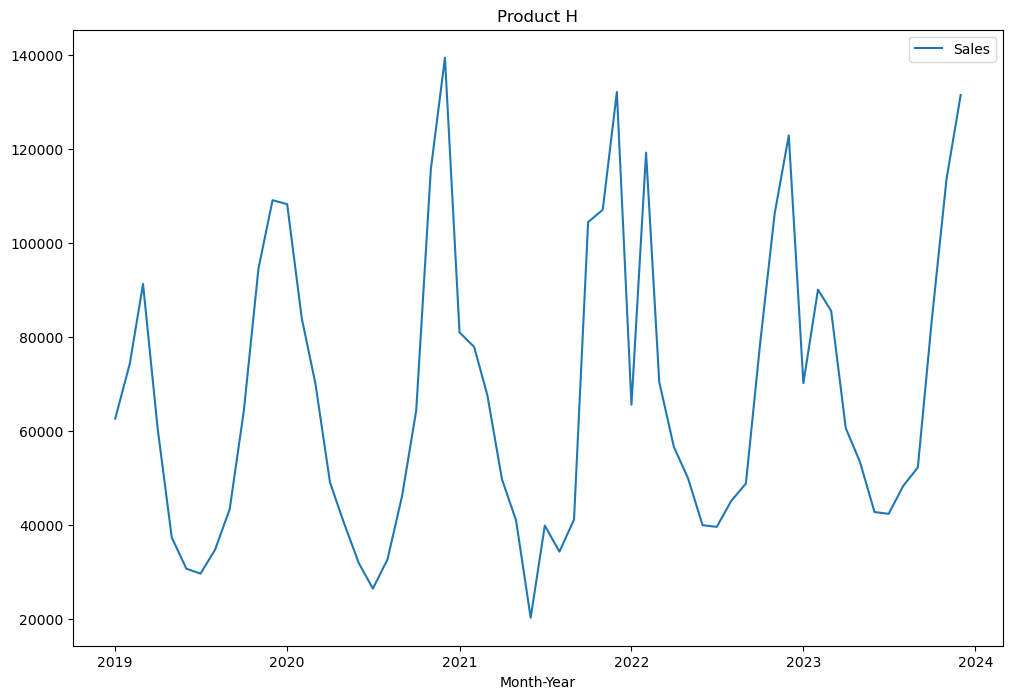

In [7]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h)
plt.title('Product H')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_h)

ADF Statistics: -1.0256008967536312
p- value: 0.7438128320877682
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_h_diff= sales_h.diff().dropna()

Text(0.5, 1.0, 'Product H- First Difference')

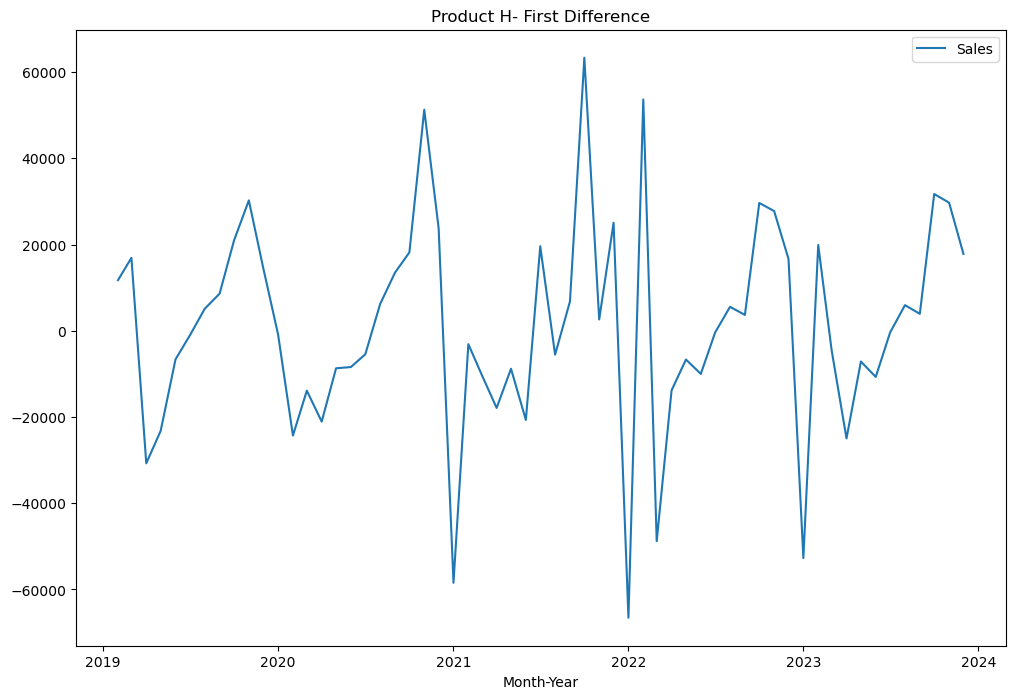

In [11]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h_diff)
plt.title('Product H- First Difference')

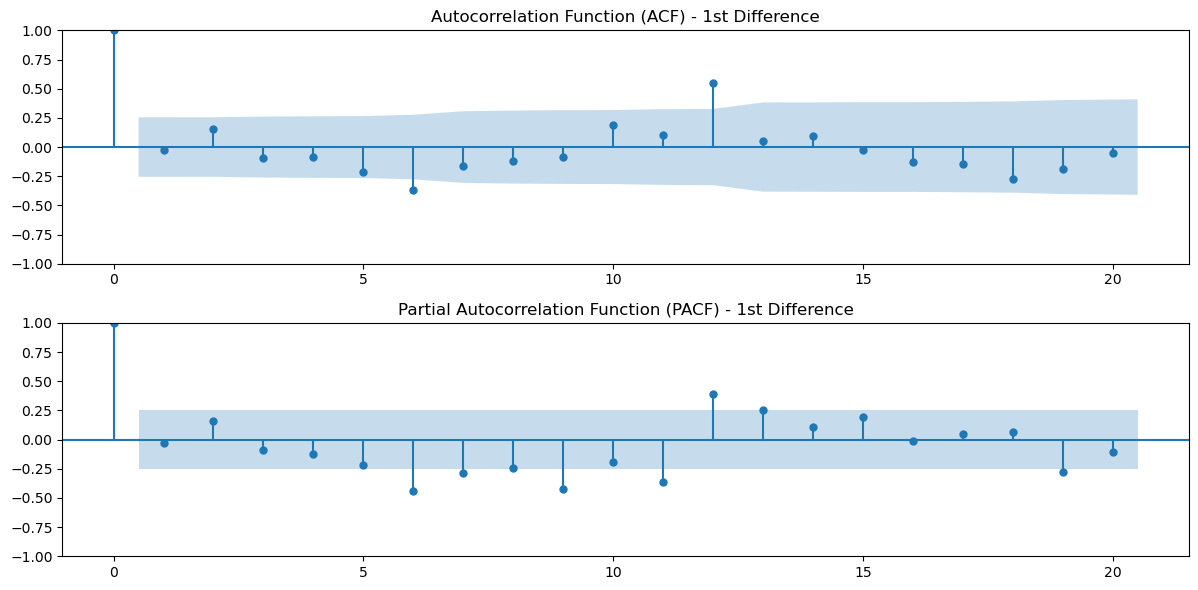

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_h_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_h_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_h_diff)

ADF Statistics: -8.916466740826941
p- value: 1.0693903940841229e-14
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_h[:54]
test=sales_h[54:]

In [15]:
len(train)

54

In [16]:
#therefore, the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(0,1,1),(0,1,2),(1,1,0),(1,1,1),(1,1,2),(2,1,0), (2,1,1), (2, 1, 2),(3,1,0),(3,1,1),(3,1,2),(4,1,0),(4,1,1),(4,1,2),(5,1,0),(5,1,1),(5,1,2)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_h, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_h)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
14  4  2  1216.431993  1230.224036  18250.320132  5.115550e+08  22617.581108
17  5  2  1217.062809  1232.825145  15516.705904  4.487742e+08  21184.291927
11  3  2  1217.270634  1229.092385  18521.736075  5.284931e+08  22988.977078
16  5  1  1222.194298  1235.986341  19292.491902  6.090241e+08  24678.414151
10  3  1  1222.248384  1232.099844  23893.107551  9.487529e+08  30801.833323
13  4  1  1222.782130  1234.603882  21164.675642  7.503400e+08  27392.335401
0   0  0  1227.577556  1229.547848  36060.666667  2.455517e+09  49553.169993
8   2  2  1228.782383  1238.633842  35494.884477  2.366376e+09  48645.413407
3   1  0  1229.435102  1233.375685  35736.936978  2.420427e+09  49197.838979
1   0  1  1229.472401  1233.412985  35786.287296  2.426111e+09  49255.565098
6   2  0  1230.091037  1236.001912  38087.340651  2.643753e+09  51417.438831
2   0  2  1230.234485  1236.145360  38110.442003  2.629473e+09  51278.385145

In [20]:
m_arima= ARIMA (train, order=(4,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   54
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -601.216
Date:                Thu, 09 May 2024   AIC                           1216.432
Time:                        18:18:49   BIC                           1230.224
Sample:                    01-01-2019   HQIC                          1221.736
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2216      0.408      2.993      0.003       0.422       2.022
ar.L2         -0.2679      0.378     -0.708      0.479      -1.010       0.474
ar.L3         -0.2892      0.363     -0.797      0.4

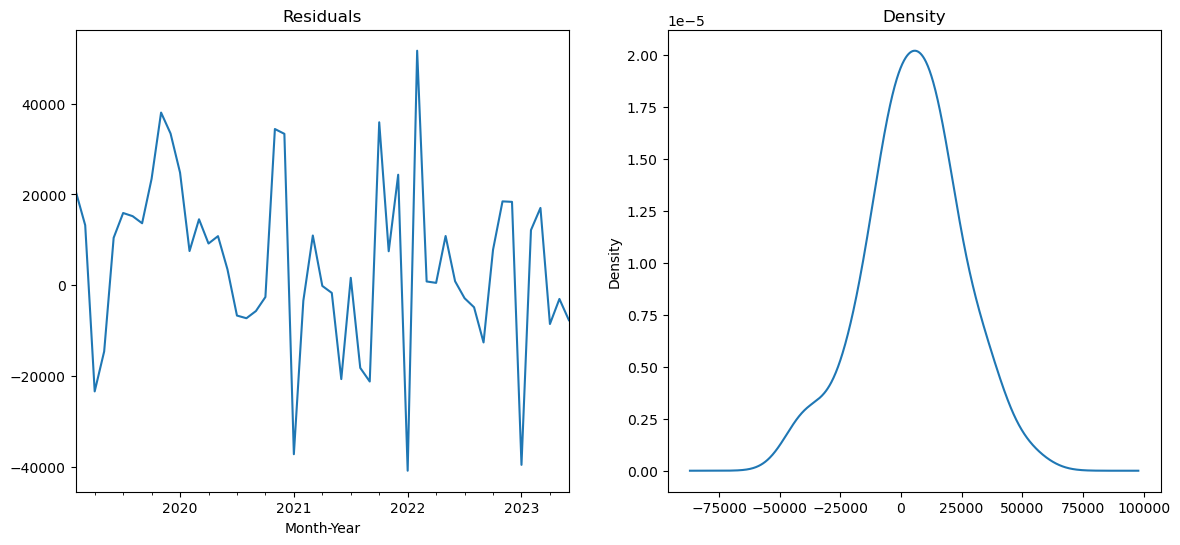

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

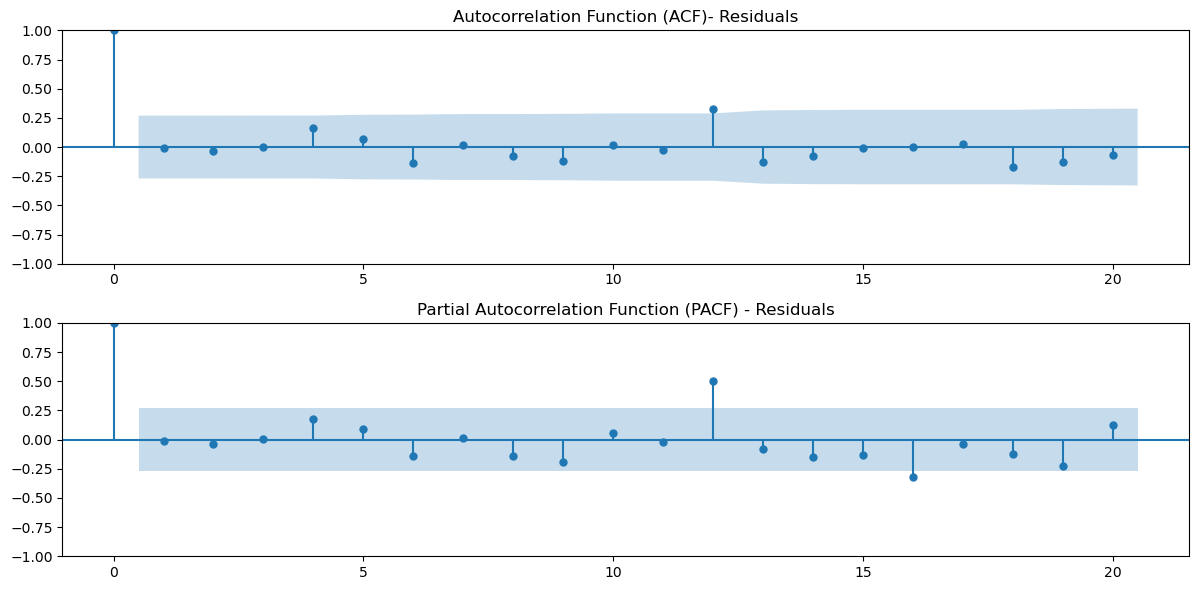

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

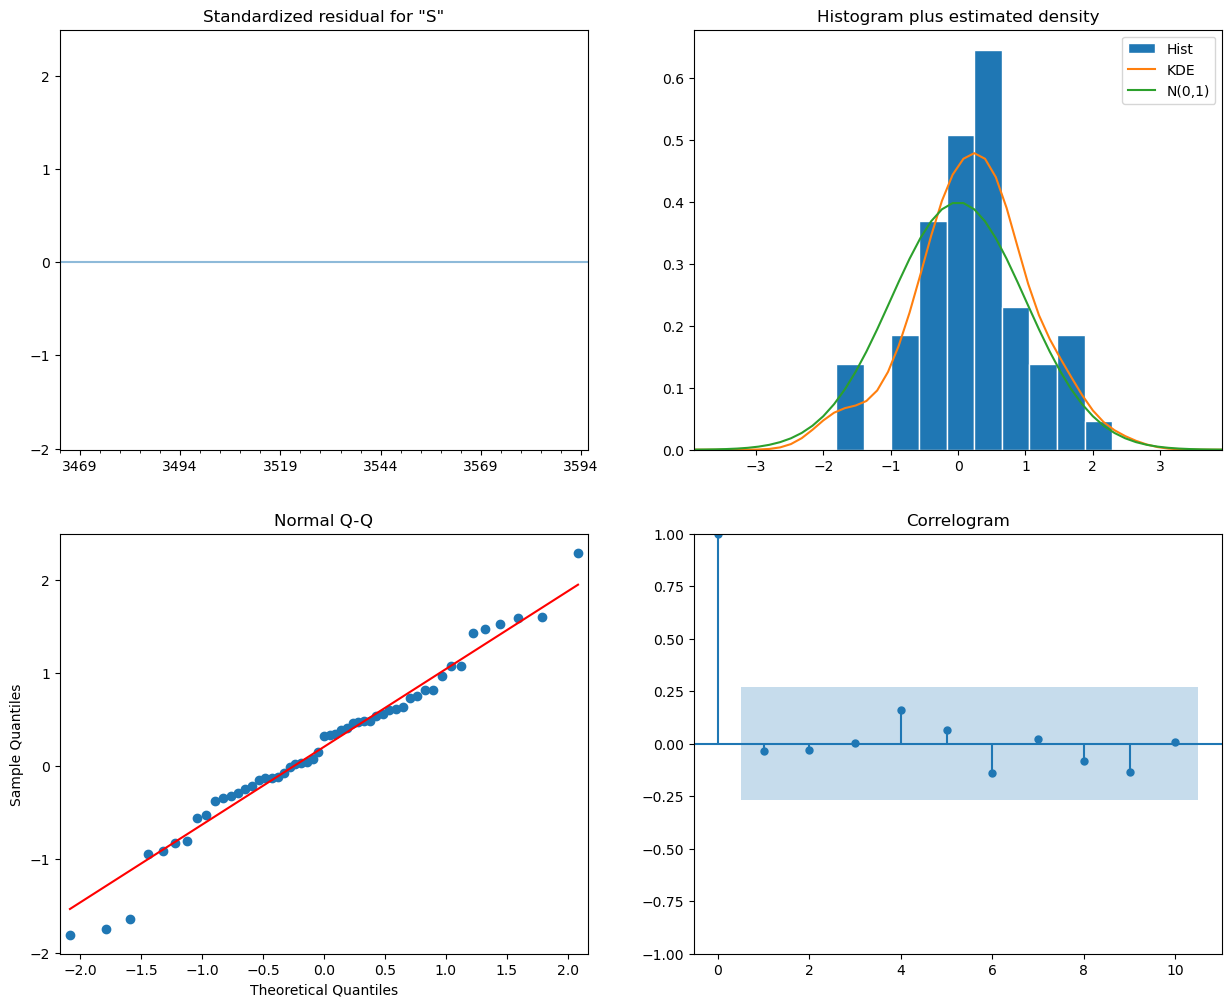

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_h['Forecast_ARIMA']=[None]*len(train) + list(pred)
#plt.figure(figsize=(14, 6))
#sales_h.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_h)-1), dynamic = True)
sales_h['Forecast_ARIMA']=[None]*len(train) + list(pred)

Text(0.5, 1.0, 'Product H')

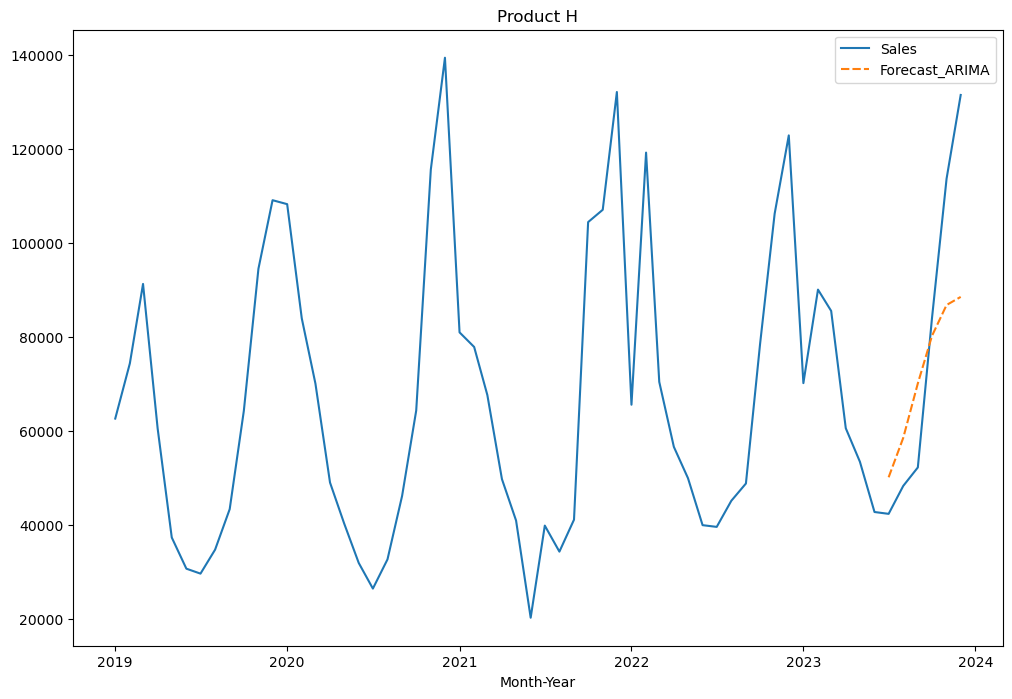

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h)
plt.title('Product H')

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 18250.320131720287
MAPE - ARIMA: 0.22411644742988324
MSE - ARIMA: 511554975.19249886
RMSE - ARIMA: 22617.581108343547


# SARIMA

In [28]:
import statsmodels.api as sm

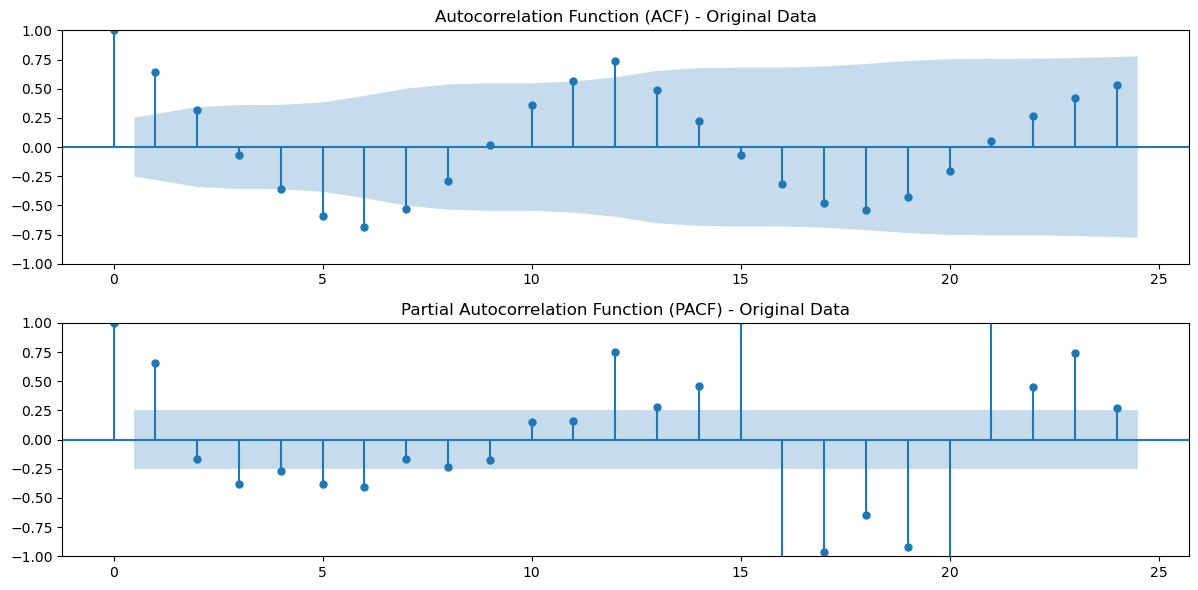

In [29]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_h['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_h['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

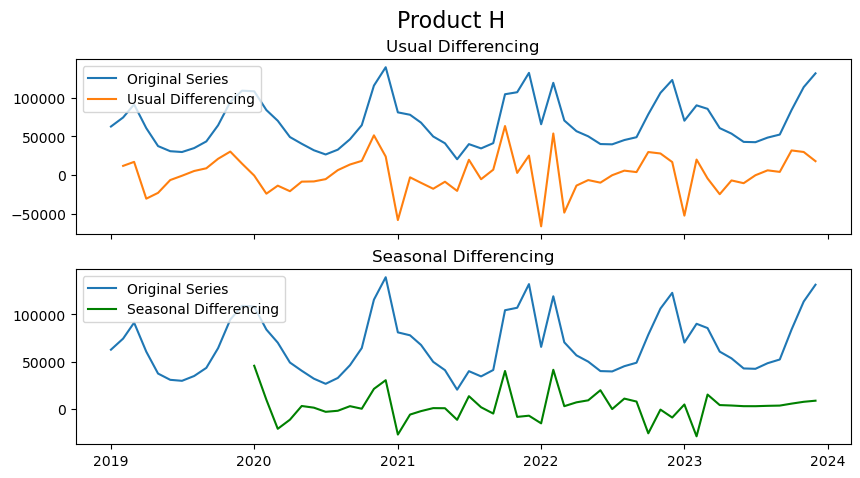

In [30]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_h['Sales'], label='Original Series')
axes[0].plot(sales_h['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_h['Sales'], label='Original Series')
axes[1].plot(sales_h['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product H', fontsize=16)
plt.show()

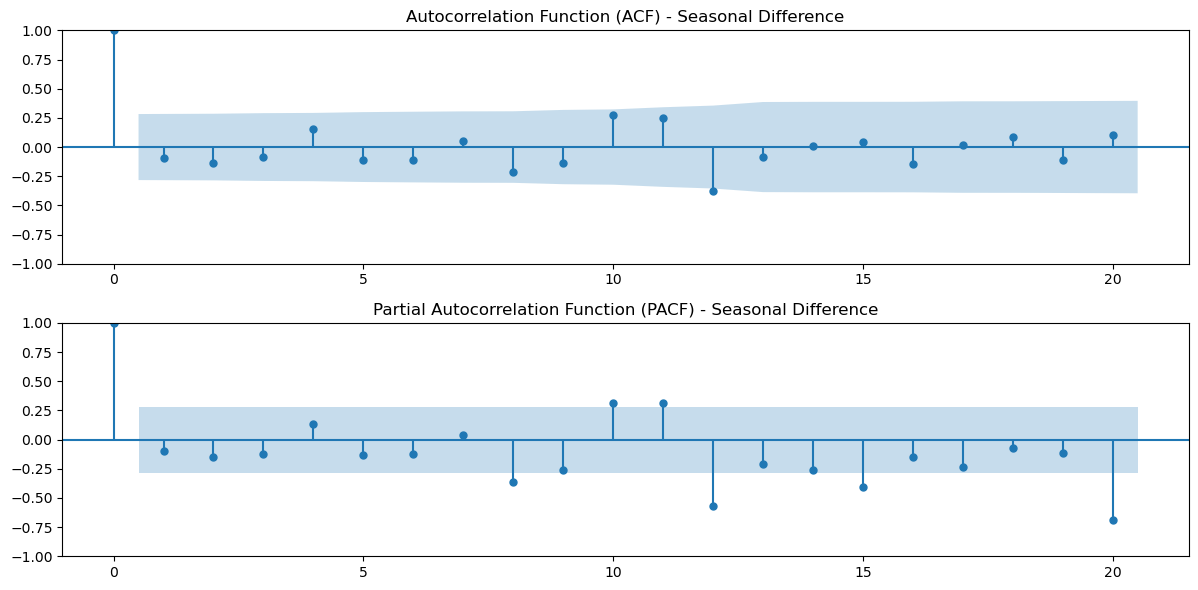

In [31]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_h['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_h['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

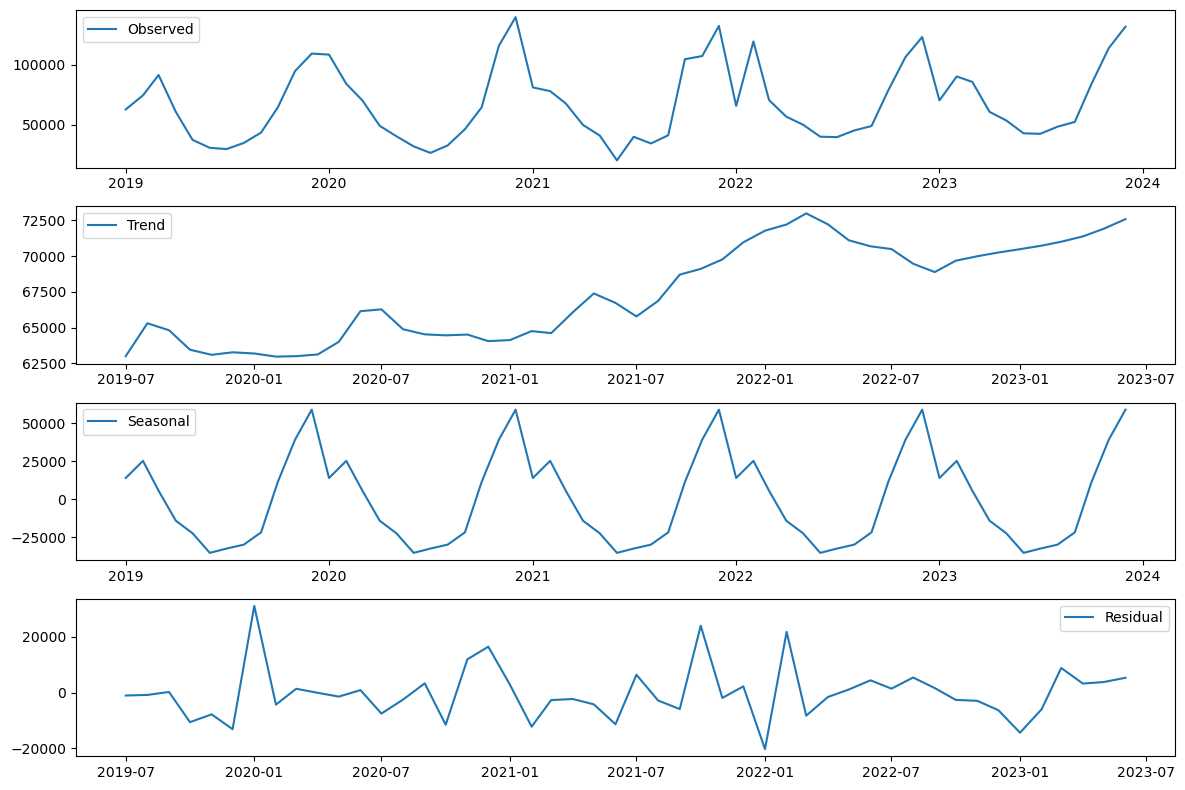

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_h['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [33]:
order_SARIMAX=[]
# Loop over P order
for P in range(5):
    # Loop over Q order
    for Q in range(3):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(4, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=54, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [34]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q         aic         bic           mae           mse
4   1  1  945.381428  960.803577   6093.245082  7.177675e+07
2   0  2  946.086348  961.508497   6867.637443  8.308101e+07
7   2  1  947.353458  964.489179   6857.849605  6.823870e+07
5   1  2  947.588175  964.723896   6053.428994  5.615198e+07
12  4  0  948.102999  966.952291  16361.587571  4.250318e+08
6   2  0  949.073318  964.495467   2534.257535  1.294544e+07
10  3  1  949.166387  968.015679   7980.314582  8.762884e+07
8   2  2  949.707748  968.557041   6899.354563  8.506175e+07
9   3  0  950.006612  967.142333   2141.669154  7.661357e+06
13  4  1  950.102882  970.665747  16373.723677  4.258451e+08
1   0  1  950.146376  963.854953   1917.669798  5.008113e+06
11  3  2  951.304089  971.866954   7153.126586  7.886225e+07
3   1  0  951.969210  965.677787   2495.273441  7.704290e+06
14  4  2  952.102915  974.379352  16367.129278  4.254014e+08
0   0  0  952.336359  964.331364   2700.653641  1.205705e+07


In [35]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(4, 1, 2),seasonal_order=(1,1,1,12))
sarima_model=sarima.fit()

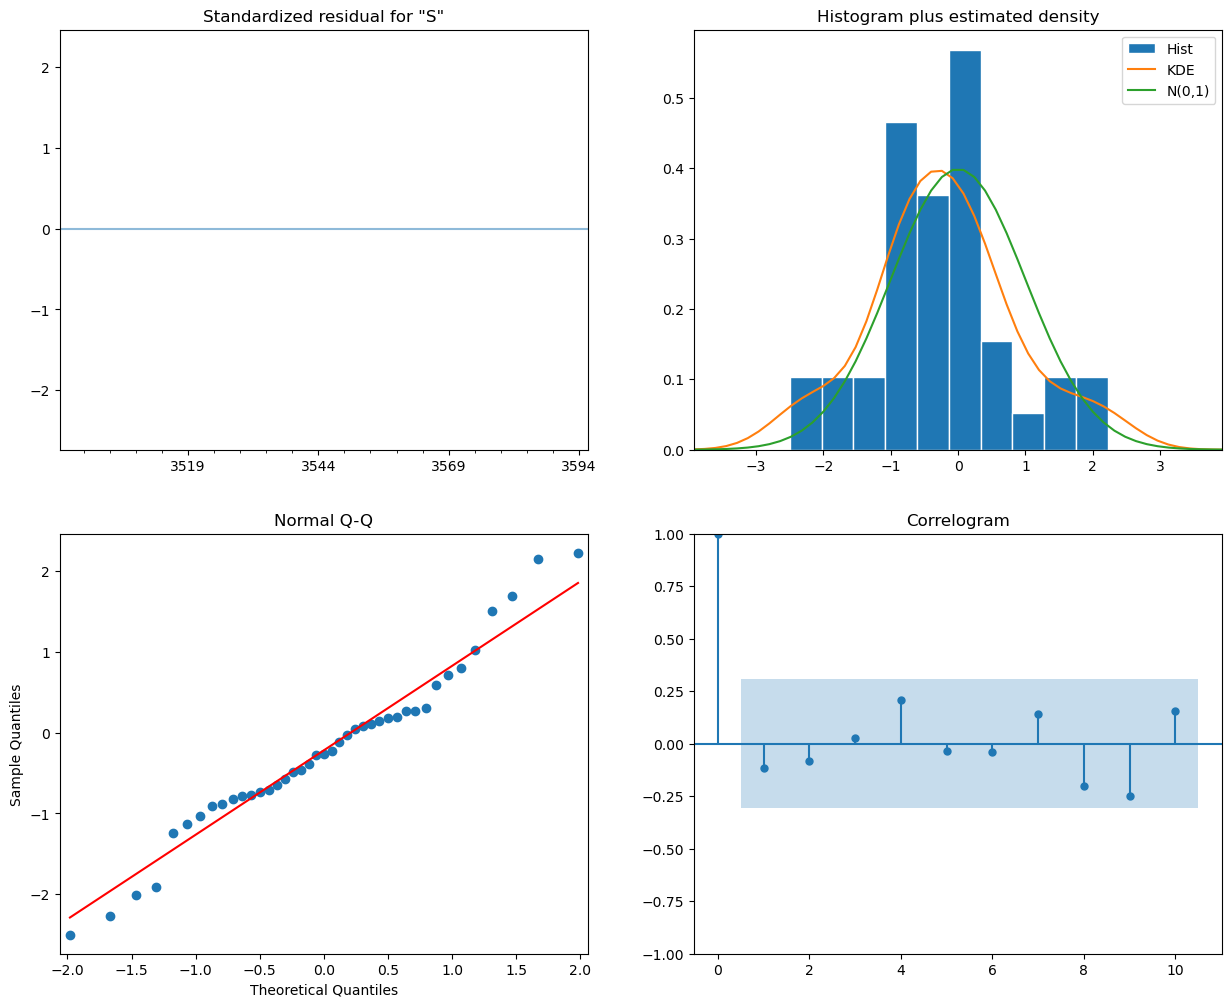

In [36]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
forecast_test_sarima=sarima_model.predict(start=54,end=59,dynamic=True)

In [38]:
sales_h['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product H')

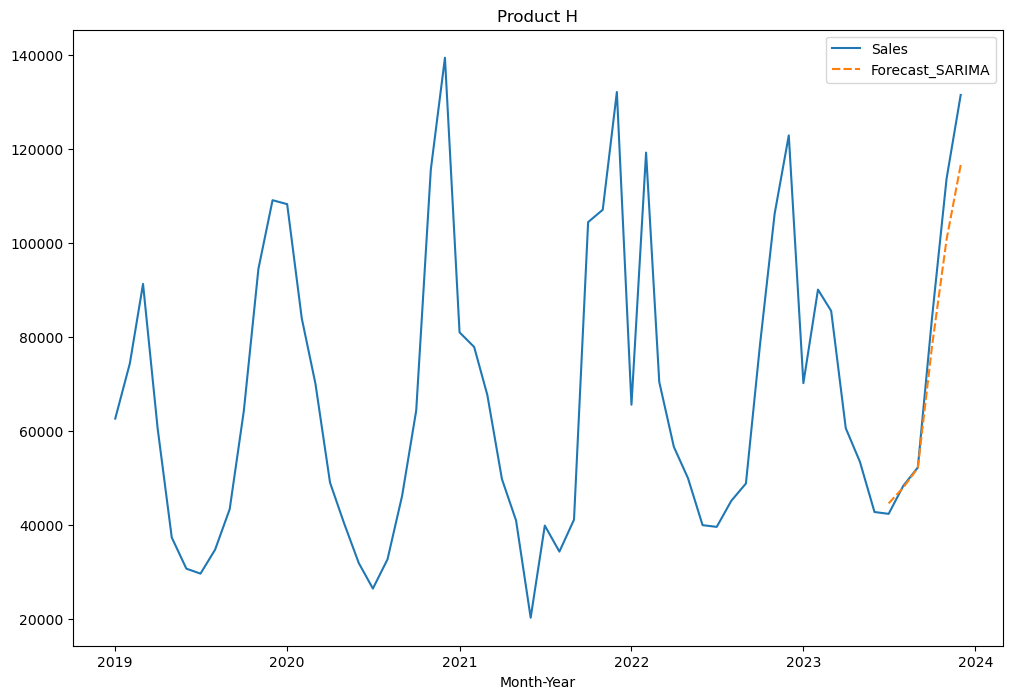

In [39]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h[['Sales','Forecast_SARIMA']])
plt.title('Product H')

In [40]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 6093.245
MAPE - SARIMA: 0.06
MSE - SARIMA: 71776745.47
RMSE - SARIMA: 8472.116


# AUTO-ARIMA

In [41]:
import pmdarima as pm

In [42]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=945.612, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=943.128, Time=0.40 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=942.959, Time=0.40 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=945.183, Time=0.12 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=944.769, Time=0.56 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=945.333, Time=0.33 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=946.355, Time=1.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=948.620, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=945.301, Time=0.28 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=947.568, Time=0.24 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.24 sec
 ARIMA(0,1,1)(2,1,0)[12]      

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [43]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   54
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -465.548
Date:                                 Thu, 09 May 2024   AIC                            939.096
Time:                                         18:25:01   BIC                            945.950
Sample:                                     01-01-2019   HQIC                           941.592
                                          - 06-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3218      0.124     -2.595      0.009      -0.565      -0.079
ma.S.L12      -0.3219      0.182     -1.770      0.077      -0.678       0.034
ma.S.L24      -0.2980      0.136     -2.194      0.028      -0.564      -0.032
sigma2      4.234e+08   1.66e-10   2.55e+18      0.000    4.23e+08    4.23e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.28   Prob(JB):                         0.55
Heteroskedasticity (H):               0.29   Skew:                            -0.06
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+34. Standard errors may be unstable.
"""

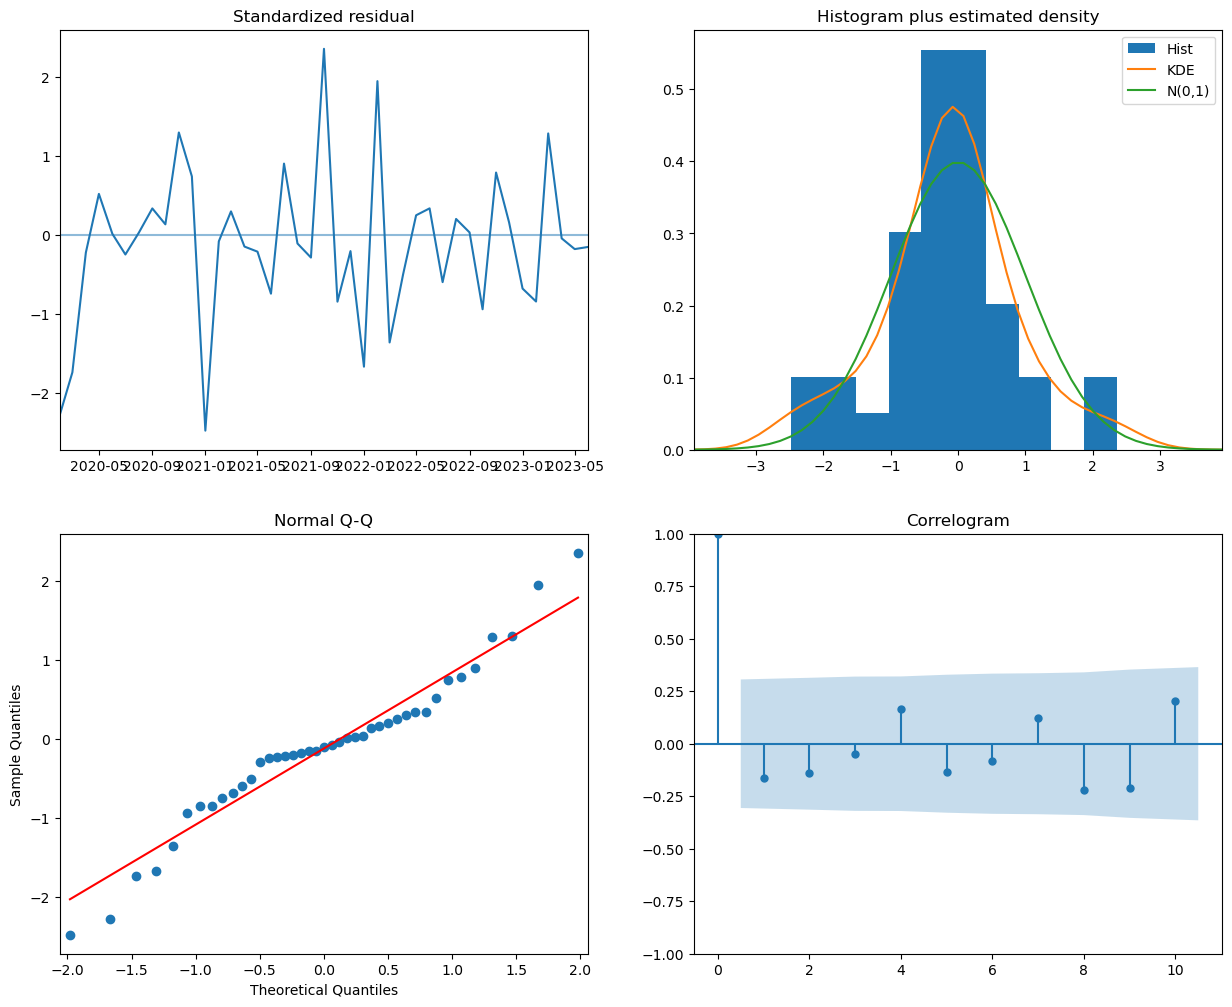

In [44]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [45]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_h['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_h.plot()

Text(0.5, 1.0, 'Product H')

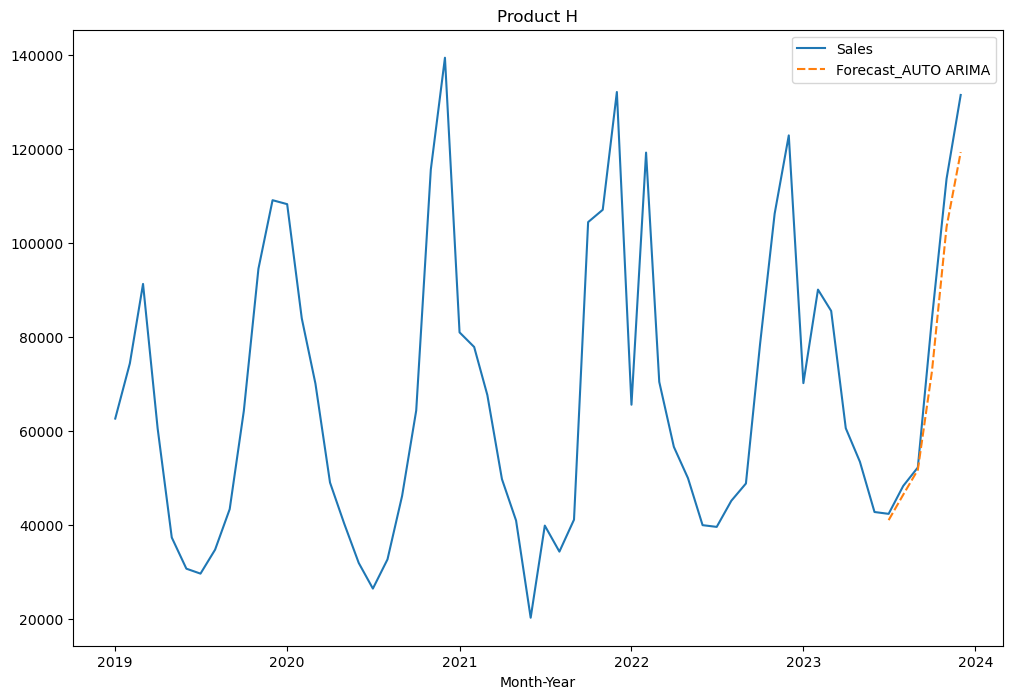

In [46]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product H')

In [47]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 6228.513241184669
MAPE - AUTO ARIMA: 0.06603875685360495
MSE - AUTO ARIMA: 64177018.37911668
RMSE - AUTO ARIMA: 8011.056008986373


In [48]:
sales_h.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,70232,NaN,NaN,NaN
2023-02-01,90139,NaN,NaN,NaN
2023-03-01,85600,NaN,NaN,NaN
2023-04-01,60633,NaN,NaN,NaN
2023-05-01,53500,NaN,NaN,NaN
2023-06-01,42800,NaN,NaN,NaN
2023-07-01,42408,50190.425133,44634.986995,41069.755422
2023-08-01,48352,58583.878678,47996.270036,46487.056796
2023-09-01,52288,70173.880944,52170.946165,51781.077194


In [49]:
sales_h.mean()

Sales                  67632.216667
Forecast_ARIMA         72446.408120
Forecast_SARIMA        73379.083916
Forecast_AUTO ARIMA    72501.486759
dtype: float64

In [50]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,18250.320132,0.224116,5.115550e+08,22617.581108
AUTO ARIMA,6228.513241,0.066039,6.417702e+07,8011.056009
SEASONAL ARIMA,6093.245082,0.060133,7.177675e+07,8472.115761


# TESTING

In [17]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=6,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=938.341, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=940.339, Time=0.06 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=941.129, Time=0.29 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=940.339, Time=0.08 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=942.005, Time=0.26 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=941.251, Time=0.28 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=942.531, Time=1.69 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=939.281, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=941.224, Time=0.20 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=942.009, Time=0.33 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=941.235, Time=0.12 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,0,1)(2,1,0)[12] i

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [18]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   54
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -467.170
Date:                  Wed, 08 May 2024   AIC                            938.341
Time:                          19:55:33   BIC                            941.816
Sample:                      01-01-2019   HQIC                           939.615
                           - 06-01-2023                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2649.1190   2717.640      0.975      0.330   -2677.357    7975.595
sigma2      2.685e+08   5.31e+07      5.055      0.000    1.64e+08    3.73e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 3.80
Prob(Q):                              0.49   Prob(JB):                         0.15
Heteroskedasticity (H):               0.54   Skew:                             0.61
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_h['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product H')

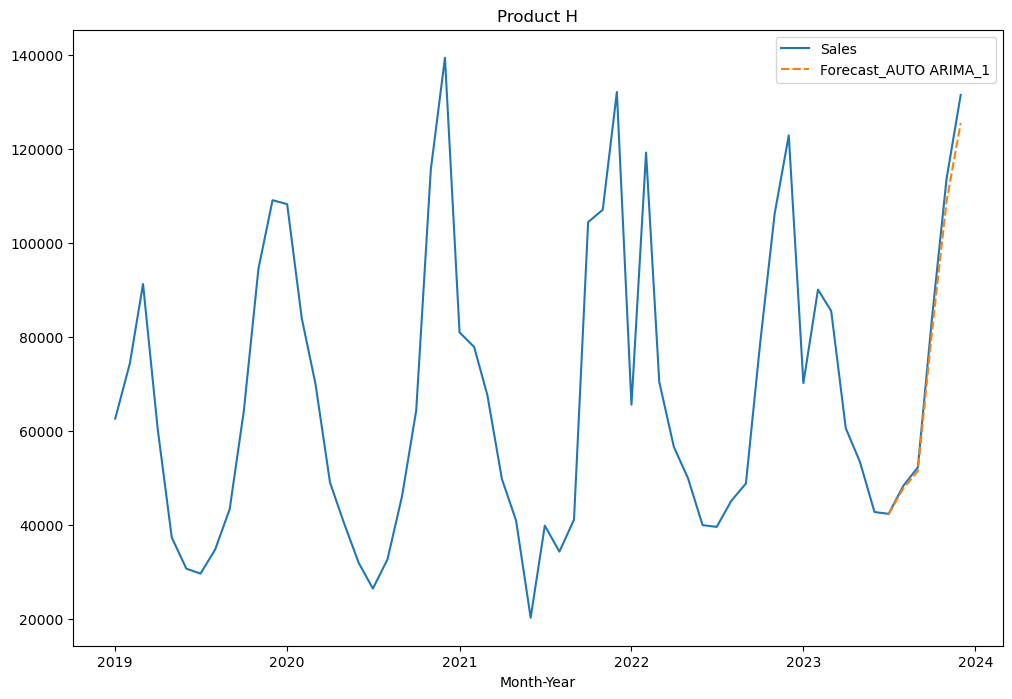

In [20]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product H')

In [21]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 2501.547619047617
MAPE - AUTO ARIMA: 0.024942424893195328
MSE - AUTO ARIMA: 11242498.045918344
RMSE - AUTO ARIMA: 3352.9834544653427
